In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
import csv
from shapely.ops import MultiPoint, Polygon, Point, voronoi_diagram
from pprint import pprint
from diversipy import subset as ss

In [2]:
SUMATIVE_COLOR_BRIGHTNESS = 300
SELECTION_COUNT = 30


BUFFER_CODE = "buffer"
TRIANGLE_CODE = "triangle"

In [3]:
#Reshapes data from the form provided by Lee filters for easier manipulation
def reshapeData(data):
    for name, values in data.items():
        temp = np.array(values[1:])
        data[name] = np.hsplit(temp,2)
        data[name][1]=data[name][1]/100.0
    return data

In [4]:
#Calculates the amount of light absorbed 
#each wavelingth when pasing through filter twice
def getDoubleFilterAbsorb(data):
    data[1]=data[1]**1
    return data

In [5]:
#Get spectra sensitivity from files
#Spectra for IMX 256 extracted form 
#https://s1-dl.theimagingsource.com/api/2.5/packages/publications/whitepapers-cameras/wpspectsens/a5cb0f39-fea8-56ae-8e04-ec20ab4e72c9/wpspectsens_1.30.en_US.pdf
#using https://automeris.io/WebPlotDigitizer/
def initSpectraSensitivity():
    camera = {}
    
    camera['red'] = np.genfromtxt('Red.csv', delimiter=';')
    camera['red'] = np.hsplit(camera['red'],2)
    camera['green'] = np.genfromtxt('Green.csv', delimiter=';')
    camera['green'] = np.hsplit(camera['green'],2)
    camera['blue'] = np.genfromtxt('Blue.csv', delimiter=';')
    camera['blue'] = np.hsplit(camera['blue'],2)
    return camera

In [6]:
def theoreticalRGBValues(filter,camera):
    result = {}
    double_filter = getDoubleFilterAbsorb(filter)
    for key,values in camera.items():
        camera_reaction = double_filter[1] * camera[key][1]
        result[key] = np.sum(camera_reaction)/np.sum(camera[key][1])
        result[key] *= 255
    return result

In [7]:
filter_data = {}
with open("chart-pdf-data.txt") as data:
    filter_data = eval(data.read())
filter_data = reshapeData(filter_data)
theory_rgb = {}
camera_spectra = initSpectraSensitivity()
for key,values in filter_data.items():
    theory_rgb[key] = theoreticalRGBValues(values,camera_spectra)
theory_rgb['327']

{'red': 1.1881142095920334,
 'green': 11.322987315777953,
 'blue': 7.7766682451789535}

In [8]:

bright_theory = dict(filter((lambda item : (item[1]['red'] + item[1]['green'] + item[1]['blue']>SUMATIVE_COLOR_BRIGHTNESS)),theory_rgb.items()))
print("all colour count: ",len(theory_rgb))
print("filtered colour count:", len(bright_theory))

all colour count:  334
filtered colour count: 192


In [9]:
#Print data in a ternary scatter plot
def showTriplot(data):
    df = pd.DataFrame.from_dict(data,orient="index")
    #print(df)
    color_list = {key: f"rgb({value['red']},{value['green']},{value['blue']})" for (key,value) in data.items()}
    fig = px.scatter_ternary(df,a="red",b="green",c="blue",color=df.index,color_discrete_map=color_list)
    fig.show()

In [10]:
print("Theoretical colors of filters \n\n")
print("Full filter set")
showTriplot(theory_rgb)
print("Bright colored filters only")
showTriplot(bright_theory)



Theoretical colors of filters 


Full filter set


Bright colored filters only


In [11]:
def check(x,y):
    for a in y:
        if x['red'] == a[0] and x['green'] == a[1] and x['blue'] == a[2]:
            return True
    return False

In [12]:

temp = [[val for val in value.values()]for value in bright_theory.values()]
temp = np.array(temp)
chosen = ss.psa_select(temp,SELECTION_COUNT)
selected = {key:val for key,val in bright_theory.items() if check(val,chosen)}
showTriplot(selected)


In [13]:
#From given 0-255 rgb values for filters computes euclidian coordinates in terenary diagram
def euclidianCords(rgbData:dict):
    npcolors =np.array([ [val for (k,val) in value.items()] for (key,value) in rgbData.items()])
    npkeys = np.array(list(rgbData.keys()))
    sums = np.sum(npcolors,1)
    normalized_rgb = npcolors/sums.reshape(sums.size,1)
    #print(npkeys.size)
    result={}
    for i in range(0,npkeys.size):
        #print(normalized_rgb[i])
        red = normalized_rgb[i][0]
        green = normalized_rgb[i][1]
        x = 1 - ((red + 2*green)/math.sqrt(3))
        y = red
        result[npkeys[i]] = [x,y]
    return result

In [14]:
def getTriangle():
    return Polygon([[0,0],[0.5,math.sqrt(3)/2],[1,0]])

In [15]:
def voronoi_volumes(points,maskCode,buffer):
    pointSet = MultiPoint(points)
    v = voronoi_diagram(pointSet)
    mask = getTriangle()
    if maskCode == BUFFER_CODE:
        mask = pointSet.envelope.buffer(buffer)
    vol = np.zeros(len(points))
    for polygon in v.geoms:
        polygon = polygon.intersection(mask)
        for i,point in enumerate(points):
            if polygon.intersects(Point(point)):
                vol[i] = polygon.area
    plt.show()
    return vol


In [16]:

def selectSpread(data,mask = TRIANGLE_CODE,buffer=0):
    cords = euclidianCords(data)
    selection = dict(data)
    while len(cords) > SELECTION_COUNT : 
        vol = voronoi_volumes(list(cords.values()),mask,buffer)
        vol = dict(zip(cords.keys(),vol))
        minimal = min(vol,key=vol.get)
        del cords[minimal]
        del selection[minimal]
    return selection

In [17]:
def showSelection(data, mask = TRIANGLE_CODE, buffer = 0):
    selection = selectSpread(data, mask, buffer)
    print(f"Selection of filters using {mask} mask and {buffer} padding")
    showTriplot(selection)
    print("Labels of selected filters")
    print(selection.keys())


In [18]:
showSelection(bright_theory)
print("\n")
showSelection(bright_theory, mask=BUFFER_CODE)
print("\n")
showSelection(bright_theory, mask=BUFFER_CODE,buffer = 0.01)
print("\n")
showSelection(bright_theory, mask=BUFFER_CODE,buffer = 0.02)


Selection of filters using triangle mask and 0 padding


Labels of selected filters
dict_keys(['002', '007', '008', '088', '100', '138', '140', '142', '144', '147', '157', '161', '192', '194', '243', '501', '505', '513', '525', '773', '795', 'SC30', 'SC60', 'B06', 'B64', 'C45', 'LD209', 'M56', 'M91', 'V98'])


Selection of filters using buffer mask and 0 padding


Labels of selected filters
dict_keys(['002', '004', '007', '036', '088', '117', '138', '140', '142', '144', '161', '170', '174', '192', '194', '203', '213', '243', '501', '513', '514', '744', '795', 'SC30', 'SC60', 'C45', 'LD209', 'M91', 'V43', 'V98'])




Exception ignored in: <function BaseGeometry.__del__ at 0x0000029600833E50>
Traceback (most recent call last):
  File "C:\Users\zbign\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\zbign\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\shapely\geometry\base.py", line 194, in _empty
    self._lgeos.GEOSGeom_destroy(self.__geom__)
KeyboardInterrupt: 


Selection of filters using buffer mask and 0.01 padding


Labels of selected filters
dict_keys(['002', '004', '007', '008', '088', '105', '138', '140', '142', '144', '157', '161', '170', '192', '194', '243', '286', '501', '513', '550', '744', '795', 'SC30', 'SC60', 'C45', 'LD209', 'M56', 'M91', 'O59', 'V98'])




KeyboardInterrupt: 

(1536, 2048)


{'index': 279,
 'record': {'index': 279,
  'endofset': True,
  'direction': 0,
  'flash': False,
  'flashselection': [0, 1, 2, 3],
  'triggertime': 1647093411.881882,
  'triggertimestring': '20220312_13:56:51.881891'},
 'img': array([[21, 22, 22, ..., 36, 34, 35],
        [22, 27, 22, ..., 46, 35, 43],
        [21, 24, 21, ..., 36, 35, 36],
        ...,
        [12,  7, 13, ...,  7,  9,  5],
        [ 9, 13, 11, ..., 13, 11, 11],
        [13,  7,  9, ...,  8, 13,  9]], dtype=uint8),
 'filename': 'photo_object_02D53783700_20220312_13:56:51.881891__0279.np'}

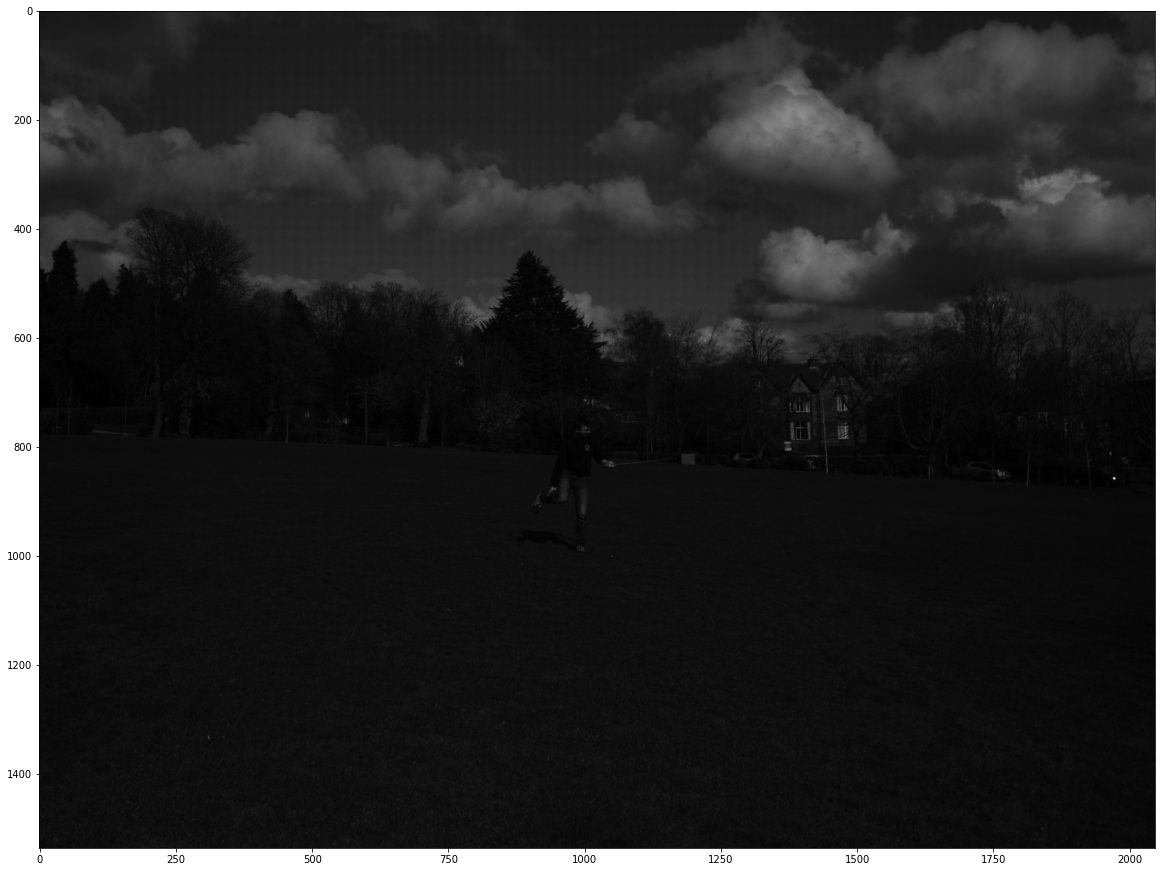

In [31]:
photo_data = np.load("Data collection 12_03_2022\photo_object_02D53783700_20220312_13_56_51.881891__0279.np",allow_pickle=True)
plt.figure(figsize=[20,20])
d = photo_data['img'].copy().astype(float)
print(d.shape)
#d = d[600:625,600:1865]

d[d>255]=255

plt.imshow(d.astype(int),"gist_gray")

photo_data

In [ ]:
photo_data = np.load("photo_object_02D53783700_20211118_14%3A14%3A37.500679__0038.np",allow_pickle=True)
photo_data['img'] = photo_data['img'].tolist()
with open('test4.csv', 'w') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames = photo_data.keys())
    writer.writeheader()
    writer.writerow(photo_data)




In [ ]:
with open('test4.csv', 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        data = row

data

Error: field larger than field limit (131072)